In [476]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

Tomando en cuenta que en las condiciones iniciales

In [477]:
g = 9.81
l = 1

E = np.array([1, 3, 5, 10, 15])

phi_init = np.pi/16
psi_init = np.pi/16
phi_dot_init = np.sqrt(E - 2*g*(1-np.cos(phi_init))- g*(1-np.cos(psi_init)))

ppsi_init = phi_dot_init*(np.cos(psi_init-phi_init))**2
pphi_init = 2*phi_dot_init

n_interation = int(10e4)

In [478]:
@jit(nopython = True)
def polar_to_cart (phi):
    x = np.zeros((2, len(phi)))
    for i in range(len(phi)):
        x[0, i] = l * np.cos(phi[i]-np.pi/2)
        x[1, i] = l * np.sin(phi[i]-np.pi/2)
    return x

vec = [$\phi$, $\psi$, $p_\phi$, $p_\psi$]

In [479]:
@jit(nopython = True)
def function (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    pphi_dot = 2*np.sin(vec[1]-vec[0])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - 2*g*np.sin(vec[0])
    ppsi_dot = 2*np.sin(vec[0]-vec[1])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - g*np.sin(vec[1]) 
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([phi_dot, psi_dot, pphi_dot, ppsi_dot])


In [480]:
@jit(nopython = True)
def Runge_Kutta (vec_angulos, h):
    k_1 = h*function(vec_angulos)
    k_2 = h*function(vec_angulos + k_1/2)
    k_3 = h*function(vec_angulos + k_2/2)
    k_4 = h*function(vec_angulos + k_3)

    return vec_angulos + (k_1 + k_2 + k_3 + k_4)/6

In [481]:
@jit(nopython = True)
def run_code(n):
    vec_Cohete_total = np.zeros((int(n_interation), 4))
    vec_Cohete_total[0] = np.array([phi_init, psi_init, pphi_init[n], ppsi_init[n]])
    t = 0
    h = 0.001
    for i in range(n_interation-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h)
        t = t+ h
    return vec_Cohete_total

In [482]:
vec_pendulo = run_code(0)
pos_pendulo_1 = polar_to_cart(vec_pendulo[:, 0])
pos_pendulo_2 = pos_pendulo_1 + polar_to_cart(vec_pendulo[:, 1])

f = open("datos.txt", "w")
for i in range(int(n_interation)):
    if i%10 == 0:
        f.write(f"{pos_pendulo_1[0, i]}, {pos_pendulo_1[1, i]}\n")
        f.write(f"{pos_pendulo_2[0, i]}, {pos_pendulo_2[1, i]}\n")
        f.write(f"\n")
f.close()

In [483]:
vec_pendulo_energias = np.zeros((len(E), int(n_interation), 4))
for i in range(len(E)):
    vec_pendulo_energias[i] = run_code(i, 0, 0)

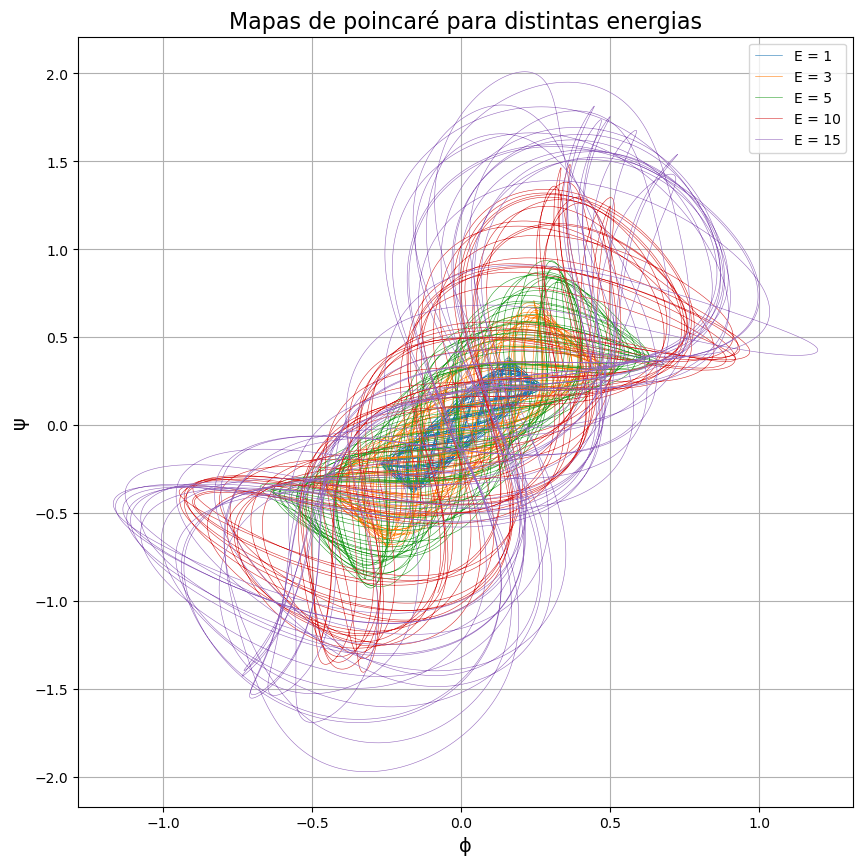

In [485]:
fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
for i in range(len(E)):
    plt.plot(vec_pendulo_energias[i][:, 0], vec_pendulo_energias[i][:, 1], label=f"E = {E[i]}", lw = 0.4)
plt.xlabel("ϕ", fontsize=14)
plt.ylabel("ψ", fontsize=14)
plt.legend()
plt.title("Mapas de poincaré para distintas energias", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/poincare_energias.png")